# Experiment: Global Precipitation

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from matplotlib.colors import LinearSegmentedColormap
from tueplots import bundles
from tueplots.constants.color import rgb

plt.rcParams.update(bundles.beamer_moml())

rb = LinearSegmentedColormap.from_list(
    "rb", [rgb.tue_blue, [1, 1, 1], rgb.tue_red], N=500
)

sys.path.insert(1, os.path.abspath(os.getcwd()[:-3]))

/home/marten/anaconda3/envs/DataLiteracy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marten/anaconda3/envs/DataLiteracy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marten/anaconda3/envs/DataLiteracy/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/marten/anaconda3/envs/DataLiteracy/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

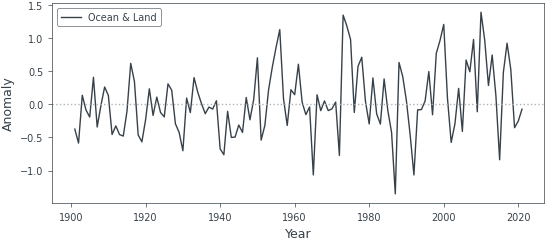

In [21]:
df = pd.read_csv(os.path.relpath('../dat/precipitation_annualy_mean.csv'), sep = ',', skiprows=6)

fig, ax = plt.subplots()

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

ax = sns.lineplot(df, x = 'Year', y = 'Anomaly [mm]', color = rgb.tue_dark, label='Ocean & Land')
ax.axhline(y=0, linewidth=1, color=rgb.tue_gray, ls=':')
